In [9]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
import regression_utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
session_num = 4
with open(f'/home/sp645/isilon/All_Staff/sp645/data/Yi_deconvoled_calcium/session{session_num}.pkl', "rb") as f:   # "rb" = read, binary
    obj = pickle.load(f)
print(type(obj))
print(obj.keys())
behavior = obj['behavior']
train_data = obj['train']
test_data = obj['test']

print(behavior.shape, train_data.shape)

Y = behavior[:,:, :2]
velocity = Y[:, 1:, :] - Y[:, :-1, :]
U = behavior[:,:, 2]# normal 0; perturbed 1
X_flatten = train_data.reshape((-1, train_data.shape[-1]))
#factors_normalized = (X_flatten - X_flatten.min()) / (X_flatten.max() - X_flatten.min())
#print(Y.shape, U.shape, X_flatten.shape, velocity.shape)

median = np.median(X_flatten, axis = 1, keepdims=True)
mad = np.median(np.abs(X_flatten - median), axis = 1, keepdims=True)

thresh = median + 3*mad
X_threshold = np.where(X_flatten > thresh, X_flatten, 0.0)
smoothed_X = gaussian_filter1d(X_threshold, sigma = 1.5, axis = 0)

velocity = np.concatenate([velocity, np.zeros((train_data.shape[0], 1 ,2))],axis = 1)
Z = np.concatenate([Y, velocity],axis = -1)
U = U
X = smoothed_X.reshape(train_data.shape)
print(Z.shape, U.shape, X.shape)



<class 'dict'>
dict_keys(['train', 'test', 'behavior'])
(140, 60, 3) (140, 60, 51)
(140, 60, 4) (140, 60) (140, 60, 51)


In [11]:
L = 0
J = 3
results_regression = regression_utils.fit_lag_model_ridge_multitrial(Z, X, U, L = L, J=J, lam_x=0.5, lam_z=0.1)
regression_utils.evaluate_lag_multitrial(results_regression, Z, X, U, L = L, J=J)

({'R2_z': 0.8755640954243679,
  'RMSE_z': 0.03659379464501185,
  'R2_x': 0.8739201492707879,
  'RMSE_x': 1.1205306402004973},
 array([[ 4.47012297e+00,  1.13980385e-01,  4.61220268e+00, ...,
          6.48109482e-02,  3.51836052e+00,  3.25888320e-01],
        [ 7.78706650e+00,  2.46780814e-01,  4.89095642e+00, ...,
          1.28703156e-01,  4.55544443e+00,  3.75031809e-01],
        [ 1.25477476e+01,  3.08352375e-01,  7.52130830e+00, ...,
          2.14072370e-01,  5.52150871e+00,  4.33455609e-01],
        ...,
        [ 3.47864708e-01,  2.29512566e+00,  2.04767776e-01, ...,
          2.52624218e-01,  2.02473482e+00,  4.34252098e+00],
        [-5.06434012e-01,  3.21735261e+00,  5.42547781e-02, ...,
          5.93021735e-01,  1.00292828e+00,  7.72864932e+00],
        [-4.76145339e-01,  3.97553064e+00,  1.01840007e-02, ...,
          8.99031050e-01,  5.84696350e-01,  1.13002220e+01]]),
 array([[4.58626766e+00, 8.51190988e-03, 5.38160253e+00, ...,
         0.00000000e+00, 4.49360272e+00, 

## Orthogonal Projection

Ctrl plane: R² = 0.802
Ctrl Plane RMSE = 0.854
eig 0: value=0.916+0.068j, vectors= [-0.99567309+0.j         -0.01386054-0.5501418j  -0.09188568+0.22013619j], 
 cos(vector, z)=0.092

eig 1: value=0.916-0.068j, vectors= [-0.99567309-0.j         -0.01386054+0.5501418j  -0.09188568-0.22013619j], 
 cos(vector, z)=0.092

eig 2: value=0.926+0.000j, vectors= [ 0.0617934 +0.j -0.19815373+0.j  0.97822118+0.j], 
 cos(vector, z)=0.978

Off-manifold eigenvalue (lambda_off): (0.9264508653823981+0j)
|lambda_off|: 0.9264508653823981


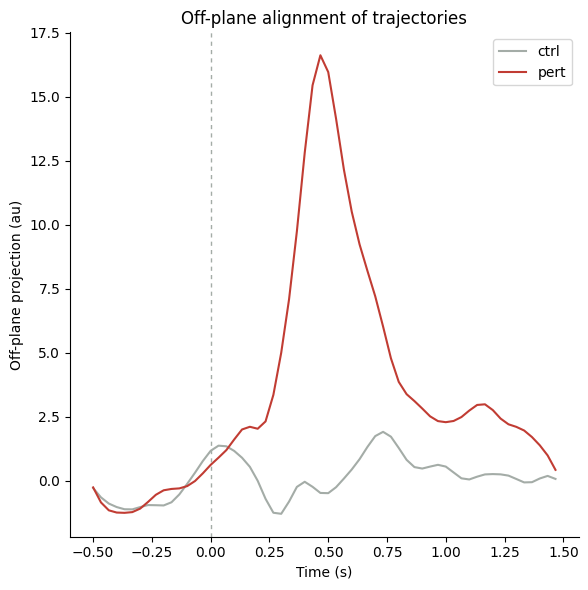

In [12]:

deviation_trial_index = np.unique(np.where(behavior[:, :, -1]==1)[0])
non_deviation_trial_index = sorted(set(range(behavior.shape[0])) - set(deviation_trial_index))


mean_control = np.mean(X[non_deviation_trial_index], axis=0)
mean_dev = np.mean(X[deviation_trial_index], axis=0)

mean_behavior_control = np.mean(Z[non_deviation_trial_index],axis = 0)
mean_behavior_dev = np.mean(Z[deviation_trial_index],axis = 0)


pca = PCA(n_components=3)
mean_data = np.vstack([mean_control, mean_dev])
mean_proj = pca.fit_transform(mean_data)

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')

colors = {'ctrl': '#a4aca7', 'pert': '#C13C33', 'passive': '#006d87'}
trajectories = {'ctrl': mean_proj[:60], 'dev': mean_proj[60:]}
# Keep only non-None fields
trajectories = {k: v for k, v in trajectories.items() if v is not None}

colors = {'ctrl': '#a4aca7', 'pert': '#C13C33'}
plane_normal_ctrl, r2_ctrl, reg_ctrl, d_ctrl = regression_utils.fit_trk_plane(trajectories['ctrl'])

rmse_ctrl = regression_utils.compute_rmse(trajectories['ctrl'], reg_ctrl)
print(f"Ctrl plane: R² = {r2_ctrl:.3f}")
print(f"Ctrl Plane RMSE = {rmse_ctrl:.3f}")
ctrl_proj_on_plane = regression_utils.project_onto_plane(trajectories['ctrl'], plane_normal_ctrl, d_ctrl)
mean_proj_rotate,Q = regression_utils.rotate_points_to_z(mean_proj, plane_normal_ctrl)

P_res = results_regression['P']
basis = pca.components_.T
P_pca = basis.T @ P_res @ basis   # (3,3)

projected_rotate_P = Q @ P_pca @ Q.T   # (3,3)

# eigenstructure analysis 

w, V = np.linalg.eig(projected_rotate_P)
z_axis = np.array([0., 0., 1.])

cosines_with_z = []
for k in range(3):
    vec = np.real(V[:, k])
    vec /= np.linalg.norm(vec)
    cos_z = np.abs(vec @ z_axis)                    # |cosine with z|
    cosines_with_z.append(cos_z)
    print(f"eig {k}: value={w[k]:.3f}, vectors= {V[:, k]}, \n cos(vector, z)={cos_z:.3f}\n")

off_idx = np.argmax(cosines_with_z)  # index of eigenvector most aligned with z
lambda_off = w[off_idx]
print("Off-manifold eigenvalue (lambda_off):", lambda_off)
print("|lambda_off|:", np.abs(lambda_off))

plt.figure(figsize=(6, 6))
frame_indices = np.arange(45, 105)       # original frames
FS_2P = 30  # Sampling rate in Hz
time_sec = (frame_indices - 60) / FS_2P 
dev_proj = mean_proj[60:]
ctrl_proj = mean_proj[:60]
# Ctrl
ctrl_out_of_plane = ctrl_proj @ plane_normal_ctrl + d_ctrl
plt.plot(time_sec, ctrl_out_of_plane, color=colors['ctrl'], linewidth=1.5, label='ctrl')

# Dev
if dev_proj is not None:
    dev_out_of_plane = dev_proj @ plane_normal_ctrl + d_ctrl
    plt.plot(time_sec, dev_out_of_plane, color=colors['pert'], linewidth=1.5, label='pert')

# Formatting
plt.axvline(0, color='#a4aca7', linestyle='--', dashes=(3, 3), linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Off-plane projection (au)")
plt.title("Off-plane alignment of trajectories")
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.savefig('Task_Norm_Proj_Session4.pdf', bbox_inches='tight', dpi=300)
plt.show()

## 2D overhead on task plane

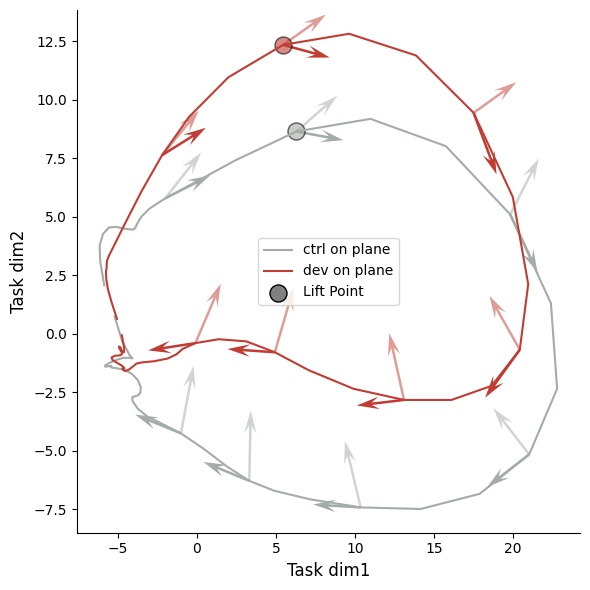

In [19]:
# ---------- HELPERS FOR VECTORS IN PCA + PLANE ----------

R = pca.components_  # (3, dx)
n = plane_normal_ctrl / np.linalg.norm(plane_normal_ctrl)

def project_vector_to_plane(v, n):
    """
    Project a 3D vector v onto a plane with unit normal n.
    """
    return v - np.dot(v, n) * n

def vec_to_dxdy(v_plane, arrow_len):
    """
    Convert a 3D plane vector to 2D quiver components,
    normalized to have fixed length arrow_len.
    """
    norm = np.hypot(v_plane[0], v_plane[1])
    if norm == 0:
        return None, None
    return v_plane[0] / norm * arrow_len, v_plane[1] / norm * arrow_len

fig2, ax2 = plt.subplots(figsize=(6, 6))
ctrl_proj_on_plane = regression_utils.project_onto_plane(ctrl_proj, plane_normal_ctrl, d_ctrl)
dev_proj_on_plane = regression_utils.project_onto_plane(dev_proj, plane_normal_ctrl, d_ctrl)
# mean_control = block_results['ctrl'][:, FRAME_SLICE].T
# mean_dev = block_results['dev'][:, FRAME_SLICE].T
eval_res_single_ctrl = regression_utils.pred_lag_multitrial(results_regression, mean_behavior_control, mean_control, np.zeros(60), L= L, J = J)
U_dev = np.ones(60)
U_dev[:17] = 0
eval_res_single_dev = regression_utils.pred_lag_multitrial(results_regression, mean_behavior_dev, mean_dev, U_dev, L= L, J = J)#U[45*60 : 46*60]
pred_next_ctrl_mean_calcium = eval_res_single_ctrl['pred_x'][0]
pred_next_dev_mean_calcium = eval_res_single_dev['pred_x'][0]
pred_next_ctrl_mean_calcium_no_control = eval_res_single_ctrl['pred_x_no_control'][0]
pred_next_dev_mean_calcium_no_control = eval_res_single_dev['pred_x_no_control'][0]
pred_next_ctrl_mean_calcium_K0 = eval_res_single_ctrl['pred_x0'][0]
pred_next_dev_mean_calcium_K0 = eval_res_single_dev['pred_x0'][0]
colors = {'dev': '#C13C33', 'ctrl': '#a4aca7'}
# Plot projected trajectories as lines (optional)
if ctrl_proj_on_plane is not None:
    ax2.plot(ctrl_proj_on_plane[:, 0], ctrl_proj_on_plane[:, 1],
             label='ctrl on plane', color=colors['ctrl'], linewidth=1.5)
if dev_proj_on_plane is not None:
    ax2.plot(dev_proj_on_plane[:, 0], dev_proj_on_plane[:, 1],
             label='dev on plane', color=colors['dev'], linewidth=1.5)

arrow_len = 0.3
quiver_index = np.arange(10, 30, 3)
projection_on_plane = {'dev': dev_proj_on_plane, 'ctrl': ctrl_proj_on_plane}
mean_traj = {'dev': mean_dev, 'ctrl': mean_control}
mean_behavior_traj = {'dev':mean_behavior_dev, 'ctrl':mean_behavior_control}
pred_traj = {'dev': pred_next_dev_mean_calcium, 'ctrl': pred_next_ctrl_mean_calcium}
pred_traj_no_control = {'dev': pred_next_dev_mean_calcium_no_control, 'ctrl': pred_next_ctrl_mean_calcium_no_control}
pred_traj_K0 = {'dev': pred_next_dev_mean_calcium_K0, 'ctrl': pred_next_ctrl_mean_calcium_K0}

# ---------- FLOW FIELD USING VECTORS (Px, Px+K0, K0) ----------

for key in ['ctrl', 'dev']:
    X_traj = mean_traj[key]

    for qi in quiver_index:
        # 1) Take original x_t in full space
        x_t = X_traj[qi+J]              # (dx,)

        # 2) POINT: base location in PCA space & on plane
        z_t = (x_t - pca.mean_) @ R.T     # (3,)
        z_t_plane = regression_utils.project_onto_plane(
            z_t[None, :],
            plane_normal_ctrl,
            d_ctrl
        )[0]

        # 3) Apply model dynamics in original space
        x_next            = pred_traj[key][qi]             # Px + K0z
        x_next_no_control = pred_traj_no_control[key][qi]  # Px
        x_next_K0         = pred_traj_K0[key][qi]          # K0z

        # 4) FLOW VECTORS in original x-space
        v_full = x_next            - x_t    # (dx,)
        v_no   = x_next_no_control - x_t    # (dx,)
        v_k0   = x_next_K0                  # (dx,)

        # 5) Project VECTORS to PCA
        v_full_pca = v_full @ R.T
        v_no_pca   = v_no   @ R.T
        v_k0_pca   = v_k0   @ R.T

        # 6) Project VECTORS onto plane
        v_full_plane = project_vector_to_plane(v_full_pca, n)
        v_no_plane   = project_vector_to_plane(v_no_pca,   n)
        v_k0_plane   = project_vector_to_plane(v_k0_pca,   n)

        # 7) Turn into 2D quiver components
        dx_full, dy_full = vec_to_dxdy(v_full_plane, arrow_len)
        dx_no,   dy_no   = vec_to_dxdy(v_no_plane,   arrow_len)
        dx_k0,   dy_k0   = vec_to_dxdy(v_k0_plane,   arrow_len)

        # Base point for all arrows
        x0 = projection_on_plane[key][qi+J, 0]
        y0 = projection_on_plane[key][qi+J, 1]

        alpha_full = 1.0
        alpha_no   = 0.5
        alpha_k0   = 0.3

        # Full flow arrow (Px + K0z)
        if dx_full is not None:
            ax2.quiver(
                x0, y0,
                dx_full, dy_full,
                angles='xy', scale_units='xy', scale=0.1,
                color=colors[key], alpha=alpha_full,
                linewidth=1.5, width=0.005,
                headwidth=5, headlength=9, headaxislength=6,
            )

        # No-control flow (Px)
        if dx_no is not None:
            ax2.quiver(
                x0, y0,
                dx_no, dy_no,
                angles='xy', scale_units='xy', scale=0.1,
                color=colors[key], alpha=alpha_no,
                linewidth=1, width=0.005,
                headwidth=5, headlength=9, headaxislength=6,
            )


proj_on_plane_dict = {
    'ctrl': ctrl_proj_on_plane,
    'dev': dev_proj_on_plane
}
for label, proj in proj_on_plane_dict.items():
    if proj is None:
        continue
    n_points = 2
    for i in range(1,n_points):
        idx = 15*i + 1
        alpha = 0.6
        edge = 'k' if idx == 16 else 'none'
        ax2.scatter(proj[idx, 0], proj[idx, 1],
                    color=colors[label], alpha=alpha, s=150,
                    edgecolor=edge, linewidth=1 if edge == 'k' else 0.5)

ax2.scatter([], [], color='gray', s=150, edgecolor='k', linewidth=1, label='Lift Point')

ax2.set_xlabel('Task dim1', fontsize=12)
ax2.set_ylabel('Task dim2', fontsize=12)
#ax2.set_title('Projections onto Control Plane', fontsize=14)
ax2.legend()
#ax2.axis(False)
ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# plt.savefig('figures/overhead_flow.svg')
#plt.savefig('overhead_flow_session4.pdf')
plt.tight_layout()
plt.show()


## 3D PCA visualization

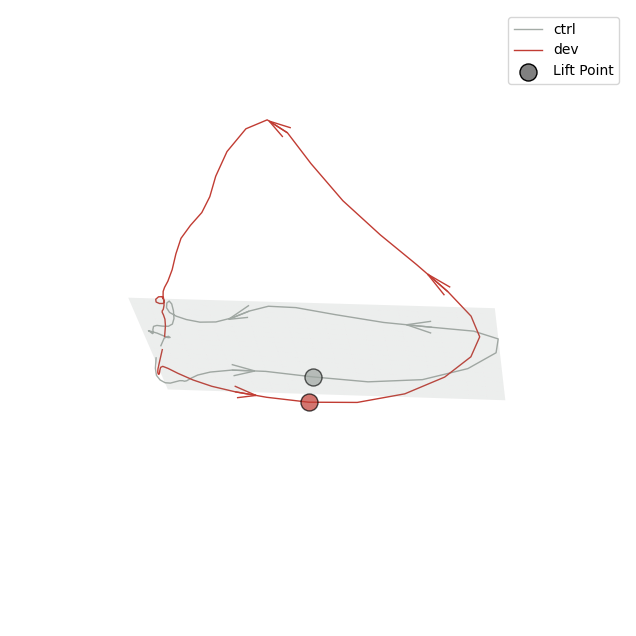

In [14]:


xlim = [ctrl_proj[:, 0].min(), ctrl_proj[:, 0].max()]
ylim = [ctrl_proj[:, 1].min(), ctrl_proj[:, 1].max()]

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 20),
    np.linspace(ylim[0], ylim[1], 20)
)
a, b = reg_ctrl.coef_ 
c = reg_ctrl.intercept_
zz = a * xx + b * yy + c

# ---------------------
# 4. Begin plotting
# ---------------------
colors = {
    'ctrl': '#a4aca7',
    'dev' : '#C13C33',
}

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xx, yy, zz, alpha=0.15, color=colors['ctrl'], edgecolor='none')


# ---------------------
# Plot trajectories
# ---------------------
ctrl_proj = trajectories['ctrl']
dev_proj = trajectories['dev']
ax.plot(ctrl_proj[:, 0], ctrl_proj[:, 1], ctrl_proj[:, 2],
        label='ctrl', color=colors['ctrl'], linewidth=1)

ax.plot(dev_proj[:, 0], dev_proj[:, 1], dev_proj[:, 2],
        label='dev', color=colors['dev'], linewidth=1)

# ------------------------------------------------
# scatter highlight
#    (colored by cos(theta) alignment)
# ------------------------------------------------
lift_pnt, step, offset = 16, 15, 16
for label, proj in trajectories.items():
    n_points = 1
    for i in range(n_points):
        idx = offset
        alpha = 0.2 + 0.8 * (i / max(n_points - 1, 1))
        edge = 'k' if idx == lift_pnt else 'none'
        ax.scatter(proj[idx, 0], proj[idx, 1], proj[idx, 2],
                   color=colors[label], alpha=0.7, s=150,
                   edgecolor=edge, linewidth=1 if edge == 'k' else 0.5)
        
    arrow_len = 2   # fixed arrow length
    quiver_index = [14, 23, 28]

    for qi in quiver_index:

        # compute direction & normalize
        dx = proj[qi+1, 0] - proj[qi, 0]
        dy = proj[qi+1, 1] - proj[qi, 1]
        dz = proj[qi+1, 2] - proj[qi, 2]
        norm = np.linalg.norm([dx, dy, dz])
        if norm == 0:
            continue
        dx = dx / norm * arrow_len
        dy = dy / norm * arrow_len
        dz = dz / norm * arrow_len

        ax.quiver(
            proj[qi, 0], proj[qi, 1], proj[qi, 2],
            dx, dy, dz,
            color=colors[label],
            linewidth=1,  
            alpha=1,
            arrow_length_ratio=1,  # controls head size in 3D
        )

ax.scatter([], [], [], color='gray', s=150, edgecolor='k', linewidth=1, label='Lift Point')

ax.grid(False)
ax.axis(False)
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([])
ax.set_xlabel(''); ax.set_ylabel(''); ax.set_zlabel('')
# ax.view_init(elev=10, azim=-70)
ax.view_init(elev=-33, azim=-85)
# Optional legend

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # RGBA
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# plt.savefig('figures/3dK1K0.svg')
#plt.savefig('3d_projection_Session4.pdf')
ax.legend()
#plt.tight_layout()
plt.show()

## orthogonal projection intrinsic vs feedback over real data projection

In [17]:
def project_vector_to_plane(v, n):
    """
    Project a 3D vector v onto a plane with unit normal n.
    """
    return v - np.dot(v, n) * n

def vec_to_dxdy(v_plane, arrow_len):
    """
    Convert a 3D plane vector to 2D quiver components (using first 2 coords),
    normalized to have fixed length arrow_len.
    """
    norm = np.hypot(v_plane[0], v_plane[1])
    if norm == 0:
        return None, None
    return v_plane[0] / norm * arrow_len, v_plane[1] / norm * arrow_len
    

R = pca.components_  # (3, dx)
n = plane_normal_ctrl / np.linalg.norm(plane_normal_ctrl)

eval_res_single_ctrl = regression_utils.pred_lag_multitrial(results_regression, Z[non_deviation_trial_index], X[non_deviation_trial_index], U[non_deviation_trial_index], L= L, J = J)
eval_res_single_dev = regression_utils.pred_lag_multitrial(results_regression, Z[deviation_trial_index], X[deviation_trial_index], U[deviation_trial_index], L= L, J = J)#U[45*60 : 46*60]
pred_next_ctrl_mean_calcium = eval_res_single_ctrl['pred_x']
pred_next_dev_mean_calcium = eval_res_single_dev['pred_x']
pred_next_ctrl_mean_calcium_no_control = eval_res_single_ctrl['pred_x_no_control']
pred_next_dev_mean_calcium_no_control = eval_res_single_dev['pred_x_no_control']
pred_next_ctrl_mean_calcium_K0 = eval_res_single_ctrl['pred_x0']
pred_next_dev_mean_calcium_K0 = eval_res_single_dev['pred_x0']
pred_next_ctrl_mean_calcium_K01 = eval_res_single_ctrl['pred_x01']
pred_next_dev_mean_calcium_K01 = eval_res_single_dev['pred_x01']
print(pred_next_dev_mean_calcium_K01.shape)

velocity_all_sessions = {'ctrl':{'intrinsic': [], 'control': [], 'full': []}, 'dev':{'intrinsic': [], 'control': [], 'full': []}}
colors = {'dev': '#C13C33', 'ctrl': '#a4aca7'}

quiver_index = np.arange(0, 60-J-1)
all_traj = {'dev': X[deviation_trial_index], 'ctrl': X[non_deviation_trial_index]}
mean_traj = {'dev': mean_dev, 'ctrl': mean_control}
mean_behavior_traj = {'dev':mean_behavior_dev, 'ctrl':mean_behavior_control}
pred_traj = {'dev': pred_next_dev_mean_calcium, 'ctrl': pred_next_ctrl_mean_calcium}
pred_traj_no_control = {'dev': pred_next_dev_mean_calcium_no_control, 'ctrl': pred_next_ctrl_mean_calcium_no_control}
pred_traj_K0 = {'dev': pred_next_dev_mean_calcium_K0, 'ctrl': pred_next_ctrl_mean_calcium_K0}
pred_traj_K01 = {'dev': pred_next_dev_mean_calcium_K01, 'ctrl': pred_next_ctrl_mean_calcium_K01}

# ---------- FLOW FIELD USING VECTORS (Px, Px+K0, K0) ----------

for key in ['ctrl', 'dev']:
    all_record = {'intrinsic': [], 'control': [], 'full': []}
    normalized_all_record = {'intrinsic': [], 'control': [], 'full': []}
    for trial_ind in range(all_traj[key].shape[0]):
        X_traj = all_traj[key][trial_ind]
        record = {'intrinsic': [], 'control': [], 'full': []}

        for qi in quiver_index:
            x_t = X_traj[qi + J]  # (dx,)

            # predicted next-state in x-space
            x_next_full = X_traj[qi + J + 1]#pred_traj[key][trial_ind, qi]             # x_{t+1} (full)
            x_next_no   = pred_traj_no_control[key][trial_ind, qi]  # x_{t+1} (no control)
            v_k01       = pred_traj_K01[key][trial_ind, qi]         # Kz_t (already a vector)

            # flows in x-space
            v_full = x_next_full - x_t
            v_no   = x_next_no   - x_t
            v_ctrl = v_k01   # since pred_x01 is Kz_t (vector contribution)

            # project vectors to PCA (NO centering for vectors)
            v_full_pca = v_full @ R.T
            v_no_pca   = v_no   @ R.T
            v_ctrl_pca = v_ctrl @ R.T

            # normal components (scalars)
            record['intrinsic'].append(v_no_pca   @ n)
            record['control'].append(v_ctrl_pca @ n)
            record['full'].append(v_full_pca     @ n)

        for k2 in all_record.keys():
            all_record[k2].append(np.array(record[k2]))

    # (n_trials, T_eff)
    for k2 in all_record.keys():
        all_record[k2] = np.array(all_record[k2])

    # time axis must match the length of quiver_index
    t = time_sec[1 + J:]  # should be length (60 - J - 1)

    normalized_all_record = all_record

    for k2 in ['intrinsic', 'control', 'full']:
        velocity_all_sessions[key][k2].append(normalized_all_record[k2])



(60, 56, 51)


(80, 56)
(80, 56)
(80, 56)
(60, 56)
(60, 56)
(60, 56)


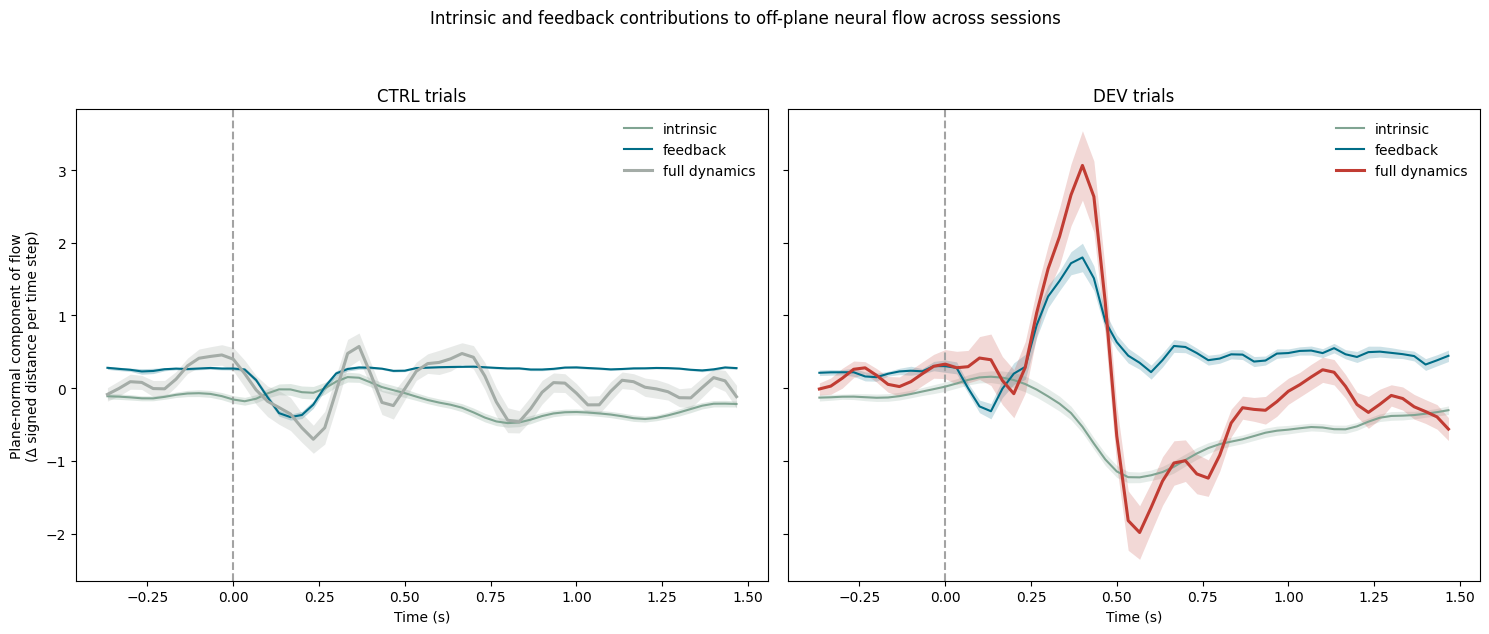

In [18]:
max_lag = 3
x = time_sec[1 + max_lag:]

# --- CTRL: different greys per component (clean + printable)
ctrl_component_color = {
    'intrinsic': '#80a492',  # dark grey
    'control':   '#006d87',  # mid grey
    'full':      '#a4aca7',  # black
}

# --- DEV: red hue for the condition, line style encodes component
dev_component_color = {
    'intrinsic': '#80a492',  # light red / pinkish
    'control':   '#006d87',  # medium red
    'full':      '#C13C33',  # dark red (dominant)
}

component_style = {
    'intrinsic': '-',   # solid
    'control':   '-',  # dashed
    'full':      '-',   # solid (we'll emphasize with thickness)
}

# Optional: make control a bit more visually distinct with dash pattern
# (comment out if you don’t want custom dash patterns)
dash_map = {
    'intrinsic': None,
    'control':   (4, 2),   # on 4, off 2
    'full':      None,
}
labels = {
    'intrinsic': 'intrinsic',   # solid
    'control':   'feedback',  # dashed
    'full':      'full dynamics',   # solid (we'll emphasize with thickness)
}
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, cond in zip(axes, ['ctrl', 'dev']):
    for comp in ['intrinsic', 'control', 'full']:
        arr = np.array(velocity_all_sessions[cond][comp][0])  # (n_sessions, T)
        print(arr.shape)
        mean = np.nanmean(arr, axis=0)
        sem  = np.nanstd(arr, axis=0) / np.sqrt(arr.shape[0])

        if cond == 'ctrl':
            color = ctrl_component_color[comp]
            ls = component_style[comp]
        else:
            color = dev_component_color[comp]
            ls = component_style[comp]

        lw = 2.2 if comp == 'full' else 1.5

        line, = ax.plot(x, mean, color=color, linestyle=ls, linewidth=lw, label=labels[comp], zorder = 2)

        ax.fill_between(
            x,
            mean - sem,
            mean + sem,
            color=color,
            alpha=0.25 if cond == 'ctrl' else 0.20,
            linewidth=0
        )

    if cond == 'ctrl':
        color = ctrl_component_color['full']
        ls = component_style['full']
    else:
        color = dev_component_color['full']
        ls = component_style['full']

    lw = 2.2                                 
    ax.axvline(x=0, color=[0.64, 0.64, 0.64], linestyle='--', linewidth=1.5, zorder = 1)
    ax.set_title(f"{cond.upper()} trials")
    ax.set_xlabel("Time (s)")

axes[0].set_ylabel("Plane-normal component of flow\n(Δ signed distance per time step)")

# You can keep legends on both, or only one:
axes[0].legend(loc="best", frameon=False)
axes[1].legend(loc="best", frameon=False)

fig.suptitle("Intrinsic and feedback contributions to off-plane neural flow across sessions", y=1.05)
fig.tight_layout()
#plt.savefig(f'off_plane_distance_change_all_session_single_trial.pdf')
plt.show()
